# Tracking the genealogy during forward simulation

This tutorial will cover several use cases of `tskit` for forward simulations.  We start with a simple Wright-Fisher simulation with no selection and no recomination, and gradually increase the complexity of our examples until we are recording mutations, ancient samples, and associated meta-data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
msprime.__version__

'0.5.0b3.dev10+g1296d0a'

## A Wright-Fisher simulation with no recombination

Here, we simulate a constant-sized Wright-Fisher (WF) population of $N$ _diploid_ individuals with no recombination and no selection.  We generate nodes and edges as we go, simplify once at the end, and add mutations with msprime.

In [3]:
def wf1(N, ngens):
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    
    # Add 2N nodes at time = 0.
    # These nodes represent the 
    # initial list of parental
    # gametes
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    for gen in range(1,ngens+1):
        assert(next_offspring_index == len(nodes))
        assert(first_parental_index == len(nodes) - 2*N)
        # Pick 2N parents
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)

            # Add nodes for our offspring's
            # two gametes
            nodes.add_row(time=float(gen))
            nodes.add_row(time=float(gen))
  
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index+1)
            
            next_offspring_index += 2
            
        first_parental_index += 2*N
        
    return (nodes,edges)

In [13]:
np.random.seed(42)
nodes, edges = wf1(100,1000)

We have to convert time from forwards to backwards, and reset the node table accordingly.

**Detail:** We also set the "flags" to 1 for each node, marking it as a sample.

In [14]:
t = nodes.time
t -= t.max()
t *= -1.0
flags = np.ones(len(nodes),dtype=np.uint32)
nodes.set_columns(time=t,flags=flags)

Our "samples" will be all nodes from the last generation simulated, which is now the nodes with `time` equal to 0.0.

In [15]:
samples=np.where(nodes.time == 0.0)[0]

We are now ready to sort, simplify, and load tables:

In [16]:
msprime.sort_tables(nodes=nodes,edges=edges)
node_map = msprime.simplify_tables(samples=samples.tolist(),nodes=nodes,edges=edges)
ts = msprime.load_tables(nodes=nodes,edges=edges)

In [17]:
for i in ts.trees():
    print(i.num_roots)

1


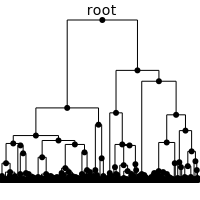

In [25]:
SVG(next(ts.trees()).draw(height=200,width=200, node_labels={len(ts.tables.nodes)-1:'root'}))